
If you have any questions, please don't hesitate to ask -- arzumanian.victoria@gmail.com (Viktoriia)

# Load dataframes for each cell lines
Load csv files from supplementary file 4

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
# Your folder
folder_path = "..."

# Initialize an empty dictionary to hold the data
dataframes = {}

# List all files in the specified folder
for filename in os.listdir(folder_path):
    # Check if the file is a CSV file
    if filename.endswith('.csv'):
        # Construct the full path to the file
        file_path = os.path.join(folder_path, filename)

        # Load the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Remove the file extension and use the file name as the key
        file_key = filename[:-4]

        # Add the DataFrame to the dictionary
        dataframes[file_key] = df

In [ ]:
#load uniprot database
#download from supplementary file 4
uniprot=pd.read_csv('...', sep=';')
uniprot.head()

In [ ]:
import pandas as pd

def process_dataframe(df, uniprot_df):
    # Merge the given dataframe 'df' with the 'uniprot_df' on the 'transcript_id' column.
    # 'uniprot_df' should have columns ['transcript_id', 'external_gene_name', 'Isoform_id'] required for the merge.
    # The merge is done using an inner join, which ensures only rows with matching 'transcript_id' are included.
    # Remove any rows with missing data using dropna().
    merged_df = pd.merge(df, uniprot_df[["transcript_id", "external_gene_name", "Isoform_id"]],
                         on='transcript_id', how='inner').dropna()

    # Define which columns in 'df' are data columns, excluding identifier and metadata columns.
    # This typically includes quantitative or measurement columns.
    data_columns = [col for col in df.columns if col not in ["transcript_id", "external_gene_name", "Isoform_id", "gene_id", "uniprotswissprot"]]

    # Group the merged data by 'external_gene_name' and 'Isoform_id', and sum the data columns for each group.
    # This aggregation is useful for combining multiple measurements or observations of the same entity.
    summarized_df = merged_df.groupby(['external_gene_name', 'Isoform_id'])[data_columns].sum().reset_index()

    # Filter out rows where all data in the data columns are less than 0.1.
    # This step removes low-value data that might not be significant for further analysis.
    merged_df = summarized_df[(summarized_df[data_columns] >= 0.1).any(axis=1)]

    # Further filter the data to include only those groups where there is more than one unique 'Isoform_id' per 'external_gene_name'.
    # This is specifically looking for genes with multiple isoforms that pass the earlier filtering steps.
    filtered_df = merged_df.groupby('external_gene_name').filter(lambda x: x['Isoform_id'].nunique() > 1)

    # Return the final filtered DataFrame which now contains aggregated and filtered data based on the conditions specified.
    return filtered_df

# Assuming 'dataframes' is a dictionary of DataFrames where each DataFrame is pre-cleaned and indexed by sample or experiment names.
# Here, the function 'process_dataframe' is applied to each DataFrame in the dictionary using a dictionary comprehension.
# The result is a new dictionary 'processed_dataframes' where each value is the processed DataFrame corresponding to each key.
processed_dataframes = {name: process_dataframe(df, uniprot) for name, df in dataframes.items()}

In [ ]:
# Define a function to calculate the log2 fold change between two values
def calculate_log2fc(max_val, second_max_val):
    # Use numpy to calculate log base 2 of the ratio of max_val to second_max_val
    return np.log2((max_val) / (second_max_val))

# Define a function to find significant genes based on their expression fold change
def find_significant_genes(df):
    significant_genes = []  # Initialize an empty list to store results
    # Select only the numeric columns from the dataframe for processing
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Group the dataframe by 'external_gene_name' and iterate over each group
    for name, group in df.groupby('external_gene_name'):
        # Iterate over each numeric column in the group
        for col in numeric_cols:
            # Filter values in the column that are greater than 1
            filtered_vals = group[group[col] > 1][col]
            # Check if there are at least two values to compare
            if len(filtered_vals) >= 2:
                # Find the maximum value in the filtered list
                max_val = filtered_vals.max()
                # Find the second largest value
                second_max_val = filtered_vals.nlargest(2).iloc[-1]
                # Calculate the log2 fold change
                log2fc = calculate_log2fc(max_val, second_max_val)
                # Check if the absolute log2 fold change is greater than 2
                if abs(log2fc) > 2:
                    # Find the isoform ID corresponding to the maximum value
                    max_isoform_id = group[group[col] == max_val]['Isoform_id'].iloc[0]
                    # Append the significant gene info to the list
                    significant_genes.append({'gene': name, 'isoform_id': max_isoform_id, 'sample': col, 'log2fc': log2fc})

    # Return a DataFrame constructed from the list of significant genes
    return pd.DataFrame(significant_genes)

# Assuming 'processed_dataframes' is a dictionary of DataFrames indexed by sample name,
# and each DataFrame has columns 'gene', 'isoform_id', and sample-specific expression data.
# Example: processed_dataframes = { 'sample1': DataFrame1, 'sample2': DataFrame2, ... }

# Initialize a dictionary to store the significant genes DataFrames for each sample
significant_genes_per_sample = {}

# Iterate over each sample and its corresponding DataFrame in 'processed_dataframes'
for sample_name, df in processed_dataframes.items():
    # Apply the 'find_significant_genes' function to find significant genes and store the result
    significant_genes_per_sample[sample_name] = find_significant_genes(df)

# Frequency of prevalence splice forms within each cell line

In [ ]:
# Create a directory for results if it does not already exist
results_dir = '...'
os.makedirs(results_dir, exist_ok=True)

results_df2 = pd.DataFrame(columns=['DataFrame Name', 'Unique Genes', 'Total Samples'])

for name, df in significant_genes_per_sample.items():
    # Count the number of unique samples for each gene-isoform pair
    gene_isoform_counts = df.groupby(['gene', 'isoform_id'])['sample'].nunique()
    # Get the total number of unique samples
    total_samples = df['sample'].nunique()

    # Calculate the frequency of occurrence for each gene-isoform pair in percentages
    gene_isoform_frequencies = (gene_isoform_counts / total_samples) * 100
    gene_isoform_frequencies_df = gene_isoform_frequencies.reset_index(name='frequency (%)')
    gene_isoform_frequencies_df['DataFrame Name'] = name

    # Create a DataFrame with the data to append
    new_data = pd.DataFrame({
        'DataFrame Name': [name],
        'Unique Genes': [gene_isoform_frequencies_df['gene'].nunique()],
        'Total Samples': [total_samples]
        })

    # Concatenate the new data with results_df2
    results_df2 = pd.concat([results_df2, new_data], ignore_index=True)

    # Merge the frequency DataFrame with the results DataFrame to link dataframes by name
    merged_df = pd.merge(gene_isoform_frequencies_df, results_df2, on='DataFrame Name')

    # Save a histogram of the frequency data to a file
    plt.figure(figsize=(10, 6))
    plt.hist(gene_isoform_frequencies_df['frequency (%)'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], alpha=0.7, color='green', edgecolor='black')
    plt.title(f'Frequency distribution of gene isoforms for {name}')
    plt.xlabel('Frequency (%)')
    plt.ylabel('Number of isoforms')
    plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    plt.grid(axis='y', alpha=0.75)
    plt.savefig(f'{results_dir}/{name}_frequency_histogram.png')
    plt.close()

    # Save the DataFrame gene_isoform_frequencies_df to a CSV file
    merged_df.to_csv(f'{results_dir}/{name}_gene_isoform_frequencies.csv', index=False)

# Relative frequency of prevalence splice forms within each cell line




In [ ]:
import pandas as pd
import os

# Assuming you have a dictionary of DataFrames each representing a sample, with significant genes per sample
# significant_genes_per_sample = {"HepG2": df1, "Sample2": df2, ...}

# Define a function to extract the prefix from an isoform identifier
def extract_prefix(isoform_id):
    # Split the isoform ID by '-' and return the first part
    return isoform_id.split('-')[0]

# Define a function to filter groups based on unique isoform prefix within each gene
def filter_groups_by_prefix(group):
    # Return the group if all isoforms in the group have the same prefix
    if group['isoform_prefix'].nunique() == 1:
        return group

# Define a function to filter groups based on having more than one unique isoform ID
def filter_groups_by_isoform_id(group):
    # Return the group if there is more than one unique isoform ID within it
    if group['isoform_id'].nunique() > 1:
        return group

# Define the output folder path where the results will be saved
output_folder = "..."
# Ensure the output folder exists, create it if it does not
os.makedirs(output_folder, exist_ok=True)

# Process each DataFrame in the dictionary of significant genes per sample
for sample_name, df in significant_genes_per_sample.items():
    # Extract the isoform prefix from the 'isoform_id' and store it in a new column
    df['isoform_prefix'] = df['isoform_id'].apply(extract_prefix)

    # Group by 'gene' and apply the prefix filter function
    filtered_df = df.groupby('gene').apply(filter_groups_by_prefix).dropna(how='all').reset_index(drop=True)

    # Optionally, apply further filtering based on the uniqueness of the isoform ID within each gene group
    filtered_df = filtered_df.groupby('gene').apply(filter_groups_by_isoform_id).dropna(how='all').reset_index(drop=True)

    # Remove the 'isoform_prefix' column as it's no longer needed after filtering
    filtered_df = filtered_df.drop(columns=['isoform_prefix'])

    # Group by 'gene' and 'isoform_id' to count the occurrences of each isoform
    isoform_counts = filtered_df.groupby(['gene', 'isoform_id']).size().reset_index(name='count')

    # Calculate the total counts of isoforms for each gene
    isoform_total_counts = isoform_counts.groupby('gene')['count'].transform('sum')

    # Calculate the frequency percentage of each isoform within its gene
    isoform_counts['frequency_percentage'] = (isoform_counts['count'] / isoform_total_counts) * 100

    # Save the isoform counts analysis to a CSV file
    counts_path = os.path.join(output_folder, f"{sample_name}_isoform_counts.csv")
    isoform_counts.to_csv(counts_path, index=False)

    # Print the path where the isoform counts file is saved for verification
    print(f"Isoform counts analysis for {sample_name} saved to {counts_path}")

#Load data "_gene_isoform_frequencies"

Number of prevalent splice forms across 10 cell lines.

In [3]:
import pandas as pd
import os
import glob

# use glob to get all the csv files
path = "your path"
csv_files = glob.glob(os.path.join(path, "*_gene_isoform_frequencies.csv"))
csv_files
data_dict_if = {}

# loop over the list of csv files
for f in csv_files:
    prefix = f.split('/',)[6]
    # read the csv file
    data_dict_if[prefix] = pd.read_csv(f, sep=',')

In [4]:
data_dict_if_clean = {}
for key, value in data_dict_if.items():
    new_key = key.replace("_gene_isoform_frequencies.csv", "")
    data_dict_if_clean[new_key] = value

In [ ]:
# Loop through the dictionary and rename the 'frequency' column for each DataFrame
for key, df in data_dict_if_clean.items():
    # Check if 'frequency' column exists to avoid KeyError
    if 'frequency (%)' in df.columns:
        df.rename(columns={'frequency (%)': key}, inplace=True)
    df.drop(columns=['DataFrame Name', 'Unique Genes', "Total Samples"], errors='ignore', inplace=True)

# Example output
for key, df in data_dict_if_clean.items():
    print(f"DataFrame: {key}")
    print(df)

In [ ]:
import pandas as pd

# Initial DataFrame to merge others onto
combined_if = None

# Iterate and merge DataFrames on 'Key'
for df in data_dict_if_clean.values():
    if combined_if is None:
        combined_if = df
    else:
        combined_if = pd.merge(combined_if, df, on=['gene', 'isoform_id'], how='outer')

In [41]:
# Create a new DataFrame to hold summarized data for plotting
cell_lines = combined_if.columns[2:]  # The cell line names
summary_data = {cell_line: {'less_than_50': 0, 'more_than_50': 0} for cell_line in cell_lines}

# Summarize the data
for cell_line in cell_lines:
    less_than_50 = combined_if[cell_line][combined_if[cell_line] < 50].count()
    more_than_50 = combined_if[cell_line][combined_if[cell_line] >= 50].count()
    summary_data[cell_line]['less_than_50'] = less_than_50
    summary_data[cell_line]['more_than_50'] = more_than_50

# Create a DataFrame for plotting
plot_if = pd.DataFrame(summary_data)

In [42]:
plot_if

,MCF7,HepG2,HCT116,MB231,K562,HeLa,A549,THP1,HEK293T,LNCAP
less_than_50,2129,2588,3069,2589,1913,2855,1626,2382,3353,1808
more_than_50,1364,1150,1171,1381,1256,1326,1447,1392,1294,1457


In [64]:
plot_if["less_than_50"]/(plot_if["less_than_50"]+plot_if["more_than_50"])*100

MCF-7         60.950472
HepG2         69.234885
HCT116        72.382075
MDA-MB-231    65.214106
K562          60.366046
HeLa          68.285099
A549          52.912463
THP-1         63.116057
HEK293T       72.154078
LNCaP         55.375191
dtype: float64

In [43]:
plot_if=plot_if.rename(columns={"THP1": "THP-1", "MCF7": "MCF-7", "MB231": "MDA-MB-231", "LNCAP": "LNCaP",})

In [44]:
plot_if=plot_if.transpose()
plot_if['Cell Line'] = plot_if.index

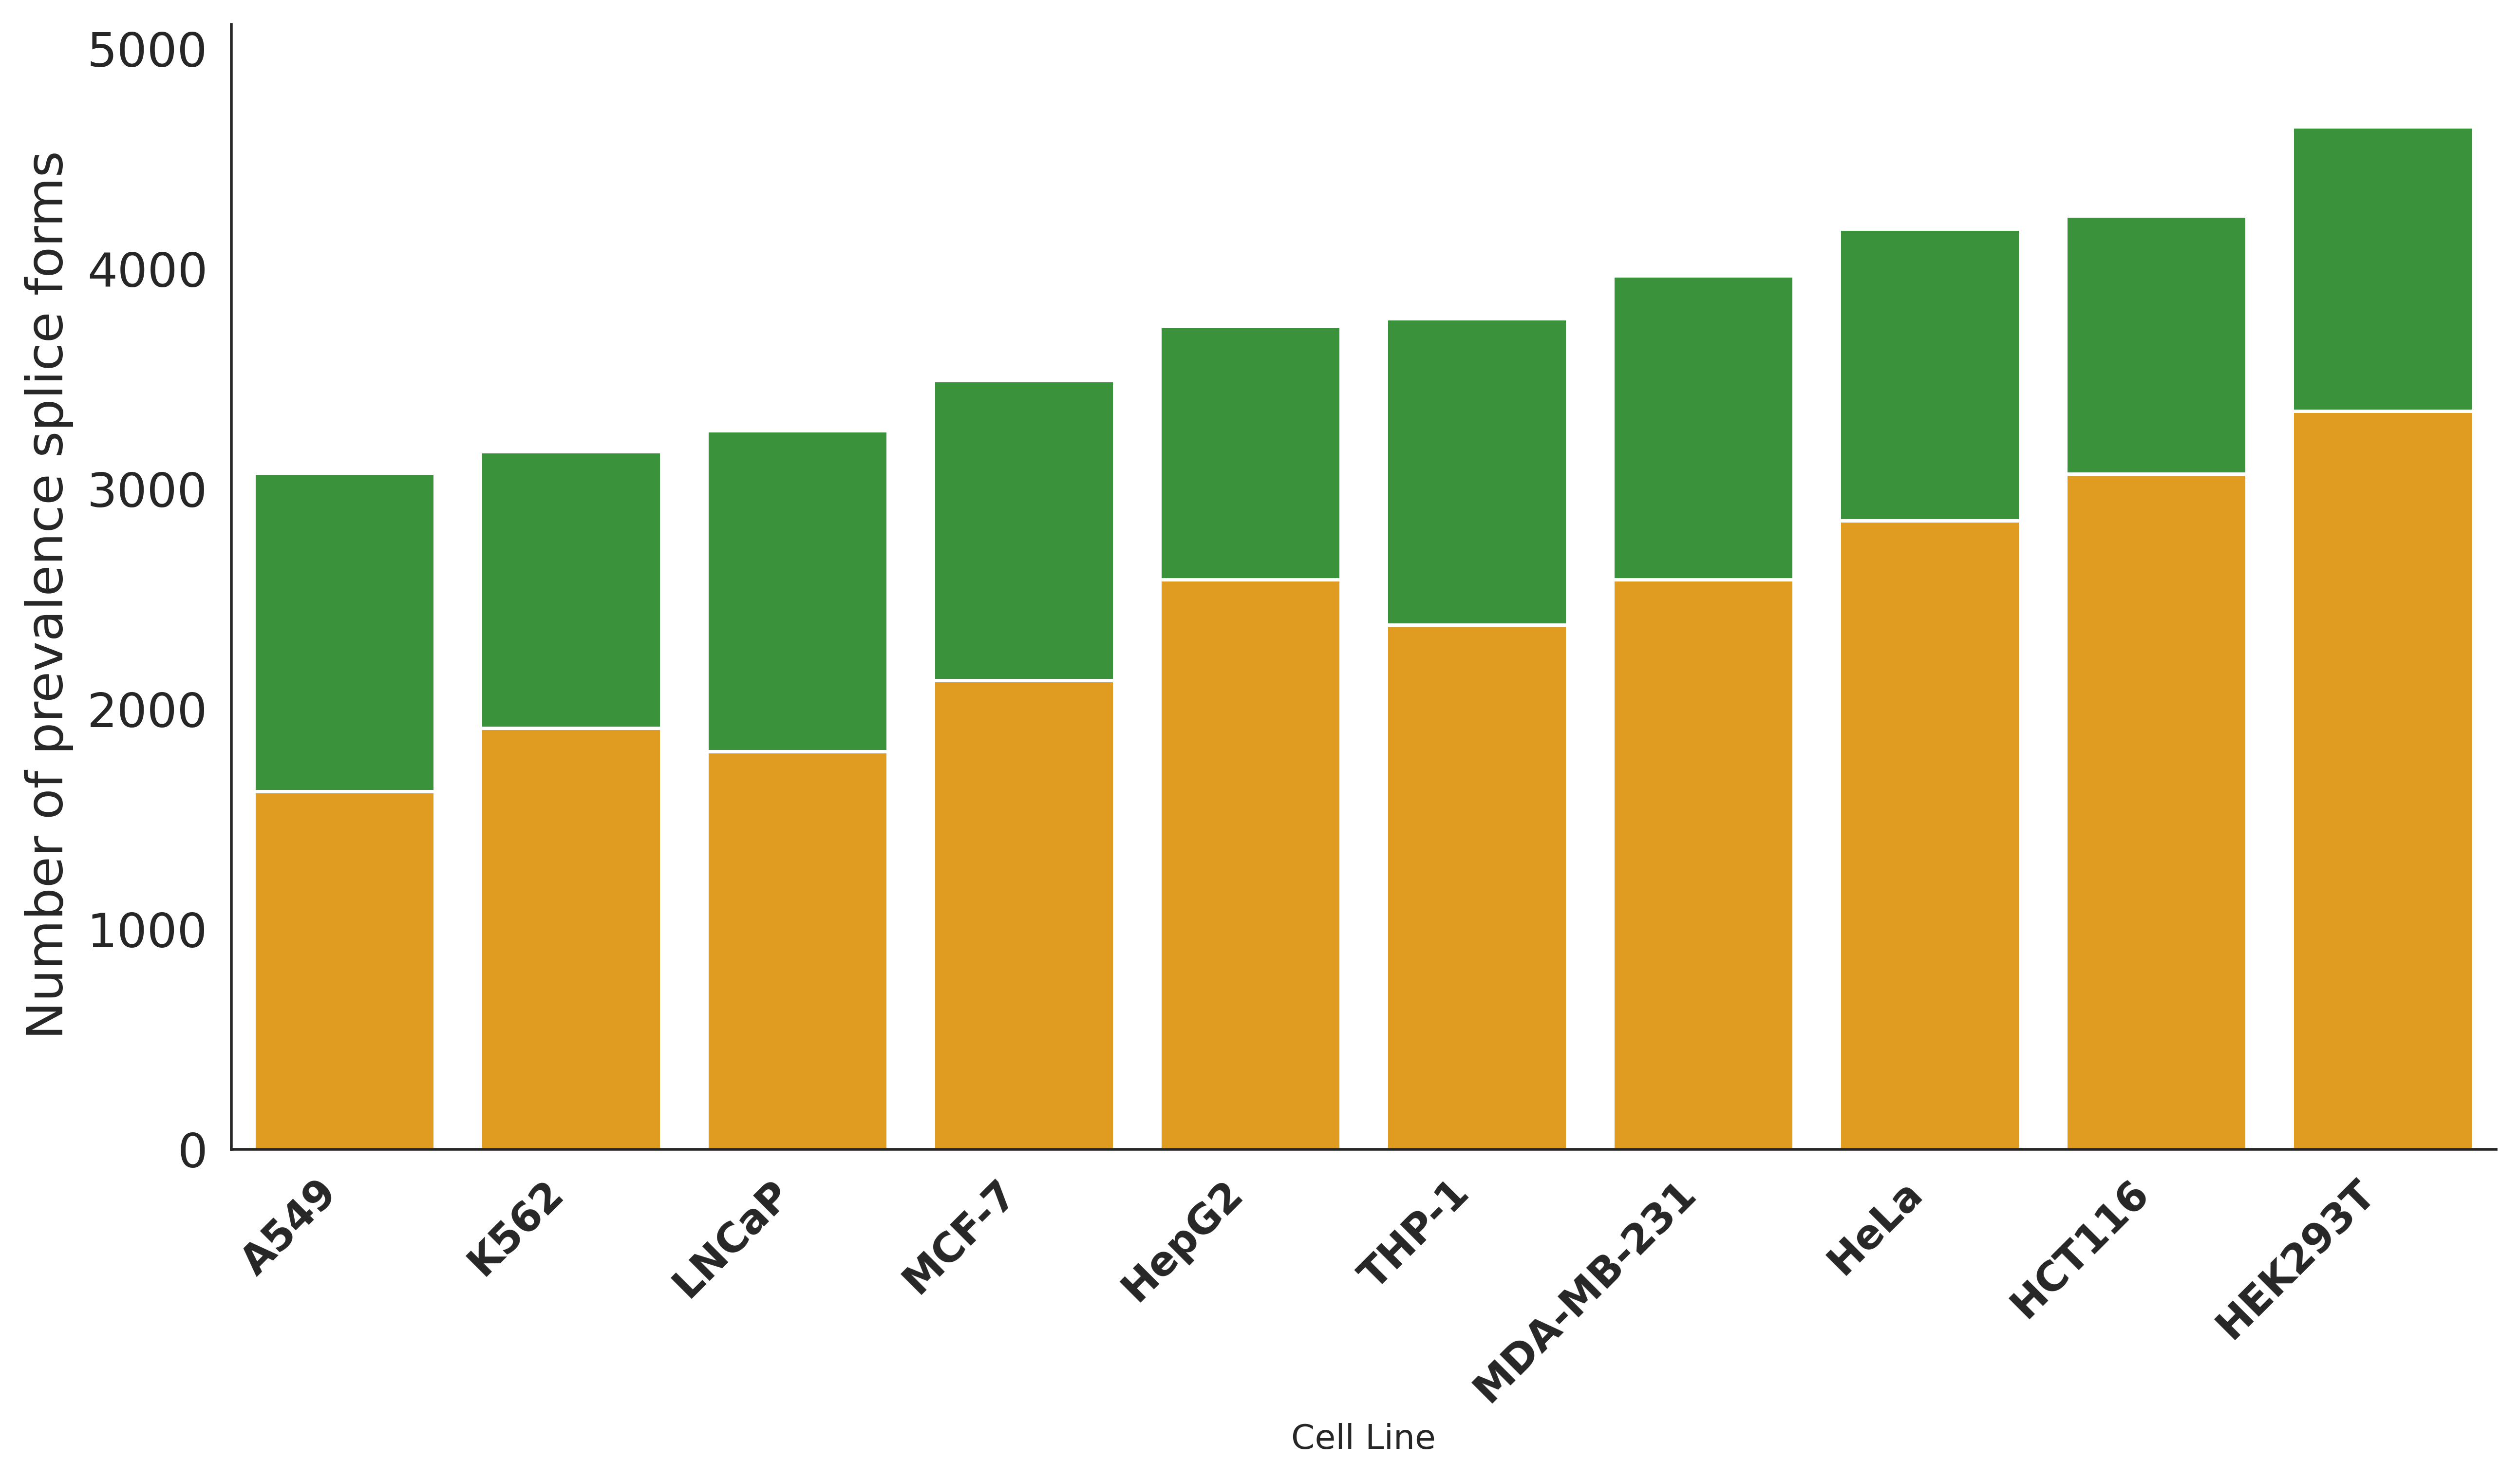

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6), dpi=500)

plot_if['total_counts'] = plot_if['more_than_50'] + plot_if['less_than_50']
df_sorted = plot_if.sort_values('total_counts', ascending=True)

sns.set_style("white")

sns.barplot(data=df_sorted, x='Cell Line', y='less_than_50', color='#FFA500')
sns.barplot(data=df_sorted, x='Cell Line', y='more_than_50', color='#2ca02c', bottom=df_sorted['less_than_50'])

plt.ylabel('Number of prevalence splice forms ', fontsize=15)
plt.xticks(fontsize=12, rotation=45, fontweight='bold', horizontalalignment='right')
plt.ylim(0, df_sorted['total_counts'].max() + (df_sorted['total_counts'].max() * 0.1))
plt.yticks(fontsize=14)

sns.despine()
plt.show()

Green bars represent the number of splice variants occurring in more than half of the samples within the same cell culture. Yellow bars indicate the number of splice forms occurring in less than half of the samples.

# Inside switching

Load data "isoform_counts"

In [24]:
# use glob to get all the csv files
# in the folder
path = "your path"
csv_files = glob.glob(os.path.join(path, "*_isoform_counts.csv"))
data_dict_inf = {}

# loop over the list of csv files
for f in csv_files:
    prefix = f.split('/',)[6]
    # read the csv file
    data_dict_inf[prefix] = pd.read_csv(f, sep=',')

Load UNIPROT database

In [28]:
import pandas as pd
uniprot_canonical=pd.read_csv("your path/Uniprot_can.csv")
uniprot_canonical=uniprot_canonical[["acc","name","status", 'geneName', 'isMain']]
uniprot_canonical= uniprot_canonical[uniprot_canonical['status'] == 'Manually reviewed (Swiss-Prot)']
uniprot_canonical=uniprot_canonical.rename(columns={"name": "isoform_id"})
uniprot_canonical.head()

,acc,isoform_id,status,geneName,isMain
0,Q8NGA8,Q8NGA8,Manually reviewed (Swiss-Prot),OR4F17,primary sequence
1,Q8NH21,Q8NH21,Manually reviewed (Swiss-Prot),OR4F5,primary sequence
2,Q96R69,Q96R69,Manually reviewed (Swiss-Prot),OR4F4,primary sequence
3,O95013,O95013,Manually reviewed (Swiss-Prot),OR4F21,primary sequence
4,Q6IEY1,Q6IEY1,Manually reviewed (Swiss-Prot),OR4F3; OR4F16; OR4F29,primary sequence


In [29]:
import pandas as pd

# Assuming df_dict is your dictionary of DataFrames
# Assuming uniprot is your DataFrame to merge with

data_dict_inf_can={}
# Iterate over the dictionary items
for key, df in data_dict_inf.items():
    # Merge the current DataFrame with uniprot_cannonical on isoform_id and gene
    merged_df = pd.merge(df, uniprot_canonical[["isoform_id", "isMain"]], on=["isoform_id"], how="left")

    data_dict_inf_can[key] = merged_df

In [30]:
import pandas as pd

# Assuming df_dict is your dictionary of DataFrames
# Assuming uniprot is your DataFrame to merge with

data_dict_inf_can={}
# Iterate over the dictionary items
for key, df in data_dict_inf.items():
    # Merge the current DataFrame with uniprot_cannonical on isoform_id and gene
    merged_df = pd.merge(df, uniprot_canonical[["isoform_id", "isMain"]], on=["isoform_id"], how="left")

    data_dict_inf_can[key] = merged_df

In [38]:
cleaned_data_dict_can = {}
for key, value in data_dict_inf_can.items():
    new_key = key.replace("_isoform_counts_v2.csv", "")
    cleaned_data_dict_can[new_key] = value

cleaned_data_dict_can

{'MCF7':        gene isoform_id  count  frequency_percentage            isMain
 0     ABCG1   P45844-1      1             50.000000  primary sequence
 1     ABCG1   P45844-5      1             50.000000               NaN
 2     ACBD5   Q5T8D3-3      1             50.000000               NaN
 3     ACBD5   Q5T8D3-4      1             50.000000               NaN
 4     ADAP1   O75689-1      1             33.333333  primary sequence
 ..      ...        ...    ...                   ...               ...
 226  ZNF644   Q9H582-3      1             16.666667               NaN
 227  ZNF839   A8K0R7-1      1             50.000000  primary sequence
 228  ZNF839   A8K0R7-5      1             50.000000               NaN
 229   ZNF92   Q03936-1      2             66.666667  primary sequence
 230   ZNF92   Q03936-2      1             33.333333               NaN
 
 [231 rows x 5 columns],
 'MB231':        gene isoform_id  count  frequency_percentage            isMain
 0     AAGAB   Q6PD74-1      1   

In [39]:
cleaned_data_dict_can['THP-1'] = cleaned_data_dict_can.pop('THP1')
cleaned_data_dict_can['MCF-7'] = cleaned_data_dict_can.pop('MCF7')
cleaned_data_dict_can['MDA-MB-231'] = cleaned_data_dict_can.pop('MB231')
cleaned_data_dict_can['LNCaP'] = cleaned_data_dict_can.pop('LNCAP')

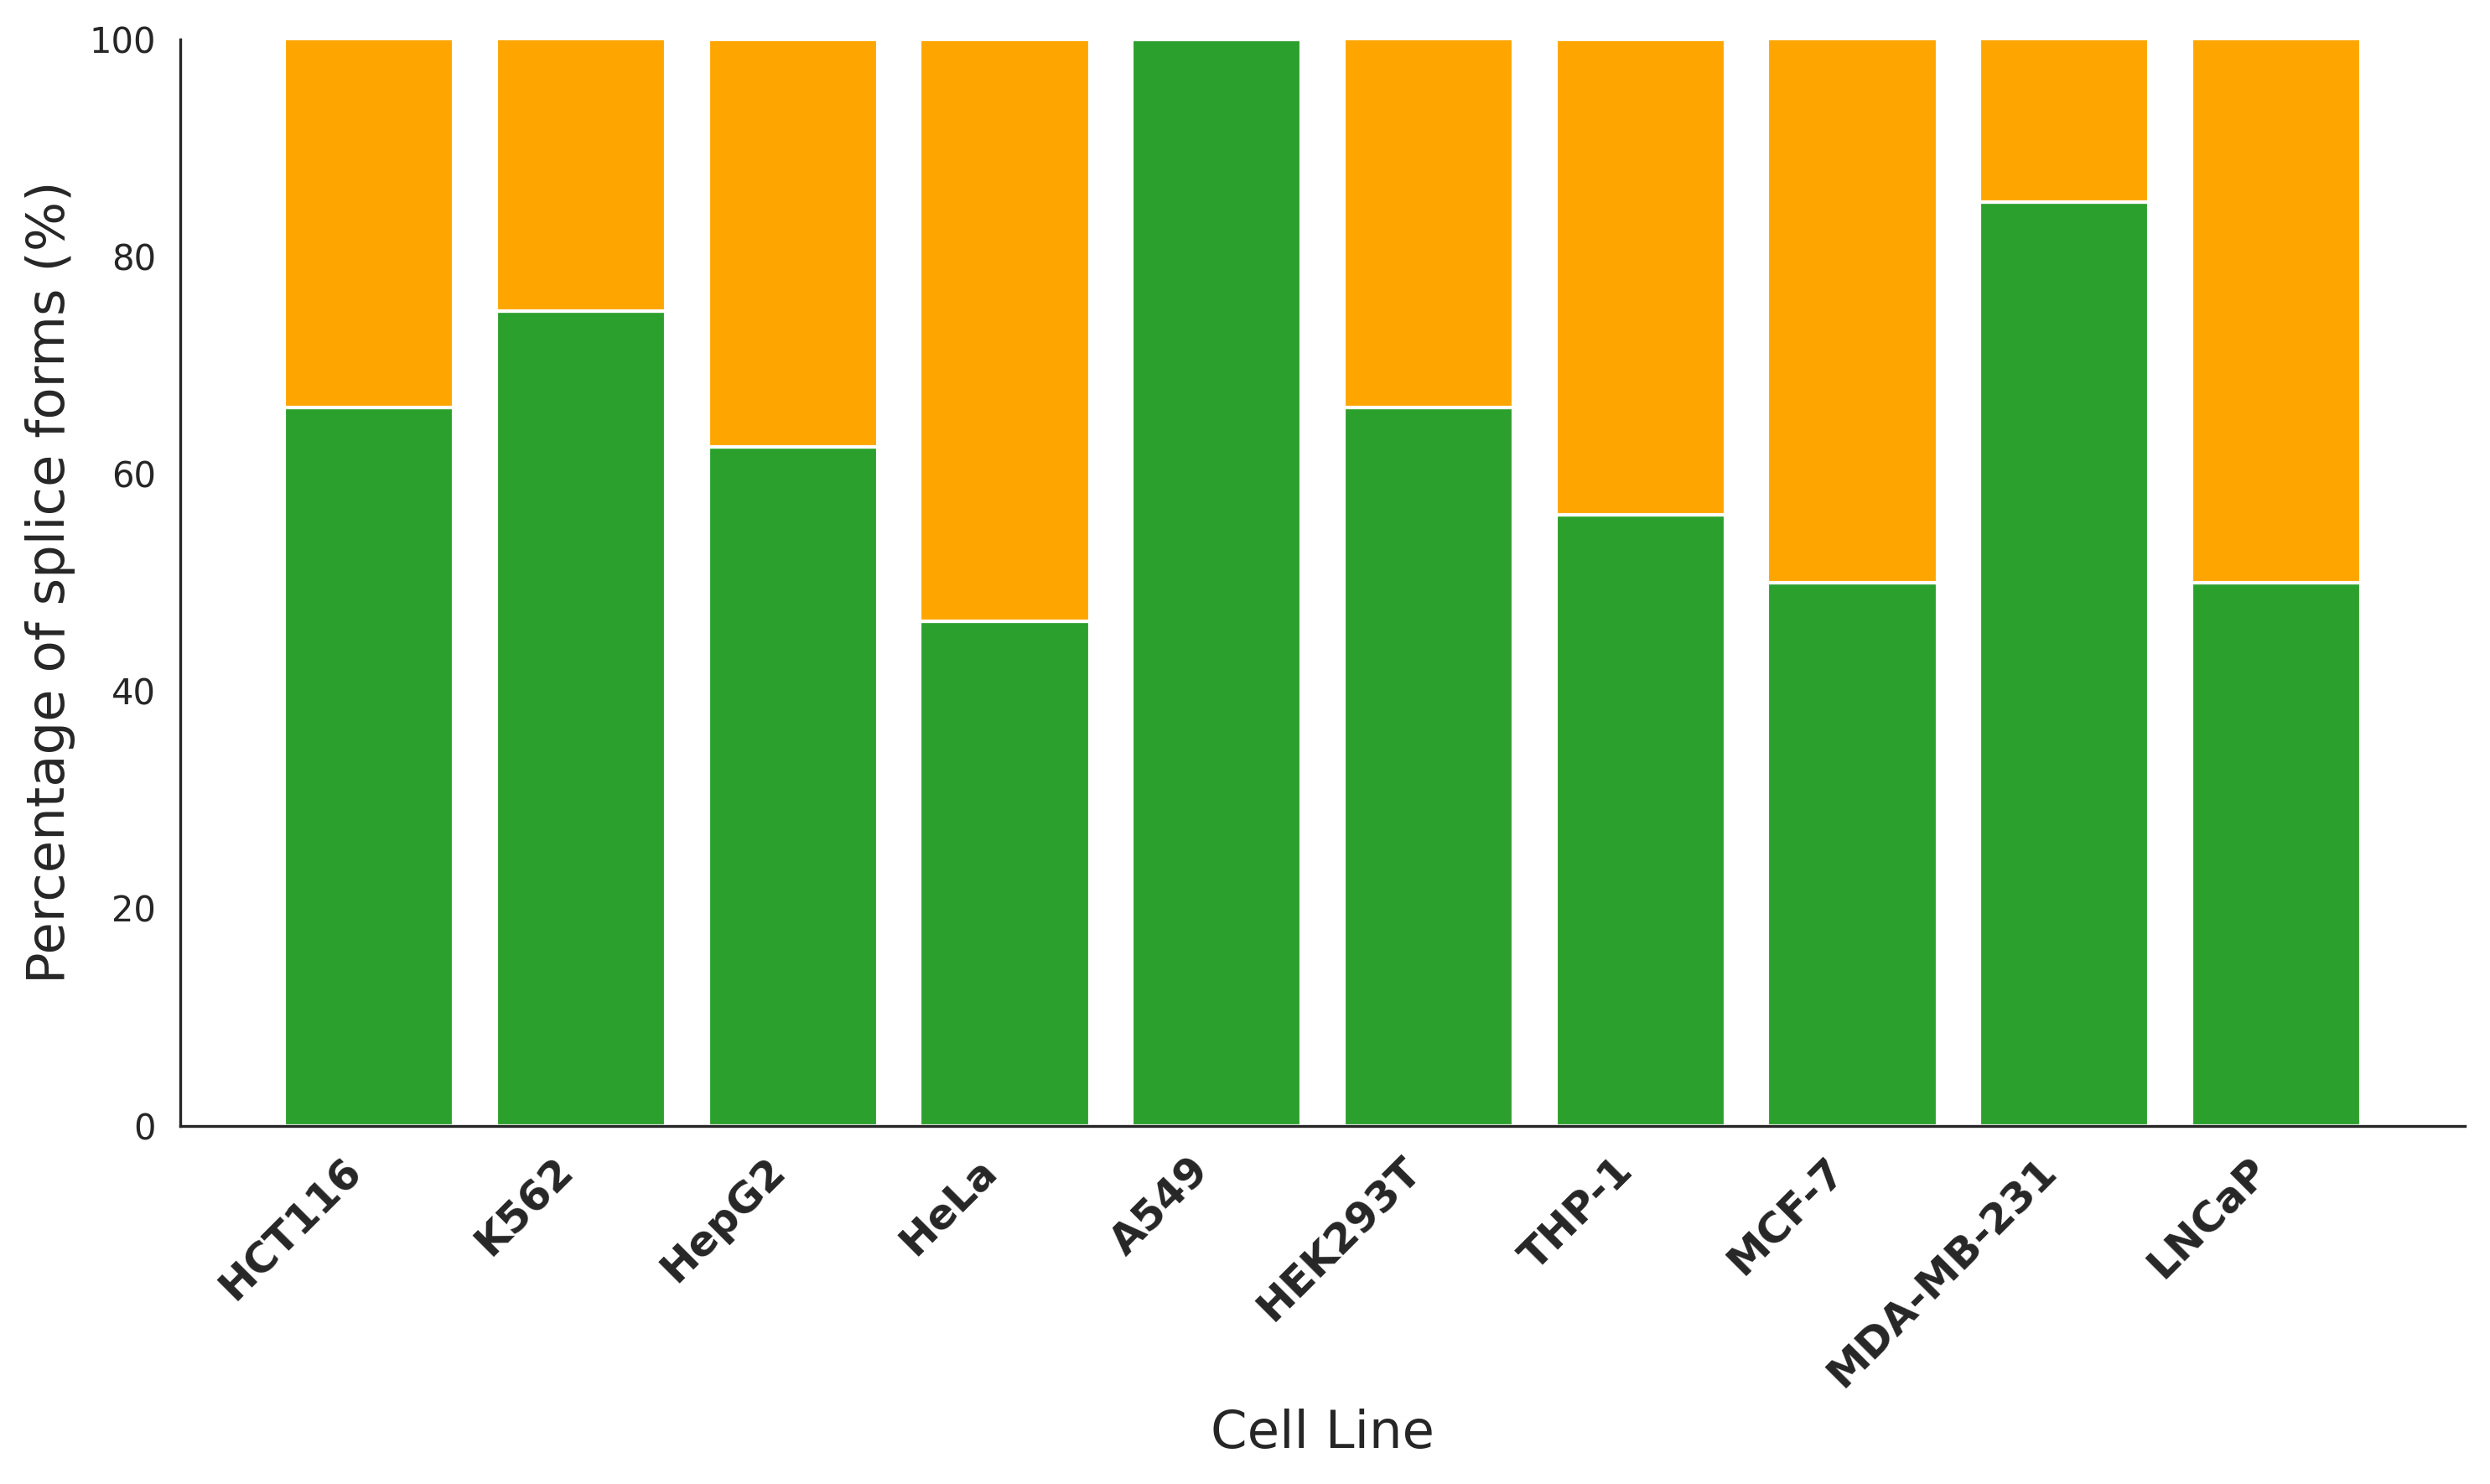

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

results = []

for key, df in cleaned_data_dict_can.items():
    # Total number of isoforms per cell line
    total_isoforms = df.shape[0]

    # Calculate counts and percentages
    Canonical = df[(df['frequency_percentage'] > 80) & (df['isMain'] == "primary sequence")].shape[0]
    NonCanonical = df[(df['frequency_percentage'] >80) & (df['isMain'].isna())].shape[0]

    # Store the results
    results.append({
        'Cell Line': key,
        'Canonical': Canonical,
        'Non Canonical':NonCanonical,
        'Total Isoforms': total_isoforms
    })

# Convert results to a DataFrame for plotting
results_df = pd.DataFrame(results).set_index('Cell Line')

# Plotting
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Calculate the bottom for the second bar segment

results_df['Canonical %'] = results_df['Canonical'] / (results_df['Canonical'] + results_df['Non Canonical']) * 100
results_df['Non Canonical %'] = results_df['Non Canonical'] / (results_df['Canonical'] + results_df['Non Canonical']) * 100

bottoms = results_df['Canonical %']

# Plot each segment of the bar
ax.bar(results_df.index, results_df['Canonical %'], color='#2ca02c')
ax.bar(results_df.index, results_df['Non Canonical %'], bottom=bottoms,  color='#FFA500')

ax.grid(False)
ax.set_ylabel('Percentage of splice forms (%)', fontsize=15)
ax.set_xlabel('Cell Line', fontsize=15)
plt.xticks(rotation=45, ha="right", fontweight='bold', fontsize=12)
#ax.set_ylim([0, 20])  # Set the y-axis max to 100%
#plt.title('Proportion of Canonical and Non Canonical Isoforms in Frequency Categories', fontsize=16)

#plt.legend()
sns.despine()
plt.tight_layout()

plt.show()

Distribution of canonical (green bars) and non-canonical (yellow bars) splice forms expressed in more than 80% of samples.

# Switching genes between cell lines

In [46]:
import pandas as pd

# Store 'gene' and 'isoform_id' before transformation
gene_isoform = combined_if[['gene', 'isoform_id']]

# Transform values: less than 5 becomes 0, 5 or more becomes 1
transformed_if = combined_if.drop(['gene', 'isoform_id'], axis=1).applymap(lambda x: 1 if x >= 50 else 0)

# Count the number of 1s (original values >= 5) for each row and calculate the percentage
transformed_if['count_more_than_5'] = transformed_if.sum(axis=1)
total_numeric_columns = len(transformed_if.columns) - 1  # Exclude the count column itself
transformed_if['percent_more_than_5'] = (transformed_if['count_more_than_5'] / total_numeric_columns) * 100

# Add the 'gene' and 'isoform_id' columns back to transformed_df
transformed_if = pd.concat([gene_isoform, transformed_if], axis=1)

print(transformed_if)

        gene isoform_id  MCF7  HepG2  HCT116  MB231  K562  HeLa  A549  THP1  \
0      AAGAB   Q6PD74-2     0      0       0      0     0     0     0     0   
1      AAMDC   Q9H7C9-1     0      0       0      0     0     0     0     0   
2     ABCA12   Q86UK0-1     0      0       0      0     0     0     0     0   
3      ABCA3   Q99758-1     1      0       0      0     1     0     0     0   
4      ABCB6   Q9NP58-1     0      0       0      0     1     1     1     0   
...      ...        ...   ...    ...     ...    ...   ...   ...   ...   ...   
7869  ZNF471   Q9BX82-1     0      0       0      0     0     0     0     0   
7870  ZNF483   Q8TF39-1     0      0       0      0     0     0     0     0   
7871  ZNF610   Q8N9Z0-1     0      0       0      0     0     0     0     0   
7872  ZNF682   O95780-1     0      0       0      0     0     0     0     0   
7873  ZNF773   Q6PK81-1     0      0       0      0     0     0     0     0   

      HEK293T  LNCAP  count_more_than_5  percent_mo

In [47]:
filtered_if = transformed_if[transformed_if['percent_more_than_5'] > 0]

print(filtered_if)

         gene isoform_id  MCF7  HepG2  HCT116  MB231  K562  HeLa  A549  THP1  \
1       AAMDC   Q9H7C9-1     0      0       0      0     0     0     0     0   
3       ABCA3   Q99758-1     1      0       0      0     1     0     0     0   
4       ABCB6   Q9NP58-1     0      0       0      0     1     1     1     0   
7       ABCC1   P33527-1     1      1       1      1     1     1     1     1   
8      ABCC10   Q5T3U5-1     1      1       0      0     1     0     0     0   
...       ...        ...   ...    ...     ...    ...   ...   ...   ...   ...   
7821    NETO1   Q8TDF5-3     0      0       0      0     0     0     0     0   
7841    RSPH1   Q8WYR4-1     0      0       0      0     0     0     0     0   
7844   SERF1A   O75920-2     0      0       0      0     0     0     0     0   
7855   TMEFF2   Q9UIK5-1     0      0       0      0     0     0     0     0   
7858  TMPRSS2   O15393-2     0      0       0      0     0     0     0     0   

      HEK293T  LNCAP  count_more_than_5

In [ ]:
filtered_if

In [48]:
duplicates_mask = filtered_if.duplicated(subset=['gene'], keep=False)

# Сохранение дубликатов в новый DataFrame, включая первое вхождение
duplicates_if = filtered_if[duplicates_mask]

print(duplicates_if)

            gene isoform_id  MCF7  HepG2  HCT116  MB231  K562  HeLa  A549  \
234        ASH2L   Q9UBL3-1     1      0       0      0     0     0     0   
922         ELP5   Q8TE02-3     0      0       0      0     0     0     1   
1002       FADS2   O95864-1     0      0       0      0     0     0     1   
1077        FLNB   O75369-1     0      0       1      0     0     0     0   
2103      PFKFB3   Q16875-3     0      0       1      0     0     0     0   
2194        PLTP   P55058-1     0      0       0      0     0     0     0   
2228     PPFIBP2   Q8ND30-1     0      0       0      0     0     0     0   
2342       PTPN6   P29350-3     1      0       0      0     0     0     0   
2721     SLC44A2   Q8IWA5-1     1      0       1      0     0     0     0   
2739         SLK   Q9H2G2-1     0      0       0      0     0     0     0   
2914     SYNCRIP   O60506-1     0      0       0      0     0     0     1   
2915     SYNCRIP   O60506-3     0      0       0      0     0     0     0   

In [49]:
duplicates_if["gene"].nunique()

17

In [55]:
duplicates_can=pd.merge(duplicates_if, uniprot_canonical[["isoform_id", "isMain"]],
                         on=["isoform_id"], how="left")

<ipython-input-56-4a4e825d7d2e>:34: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


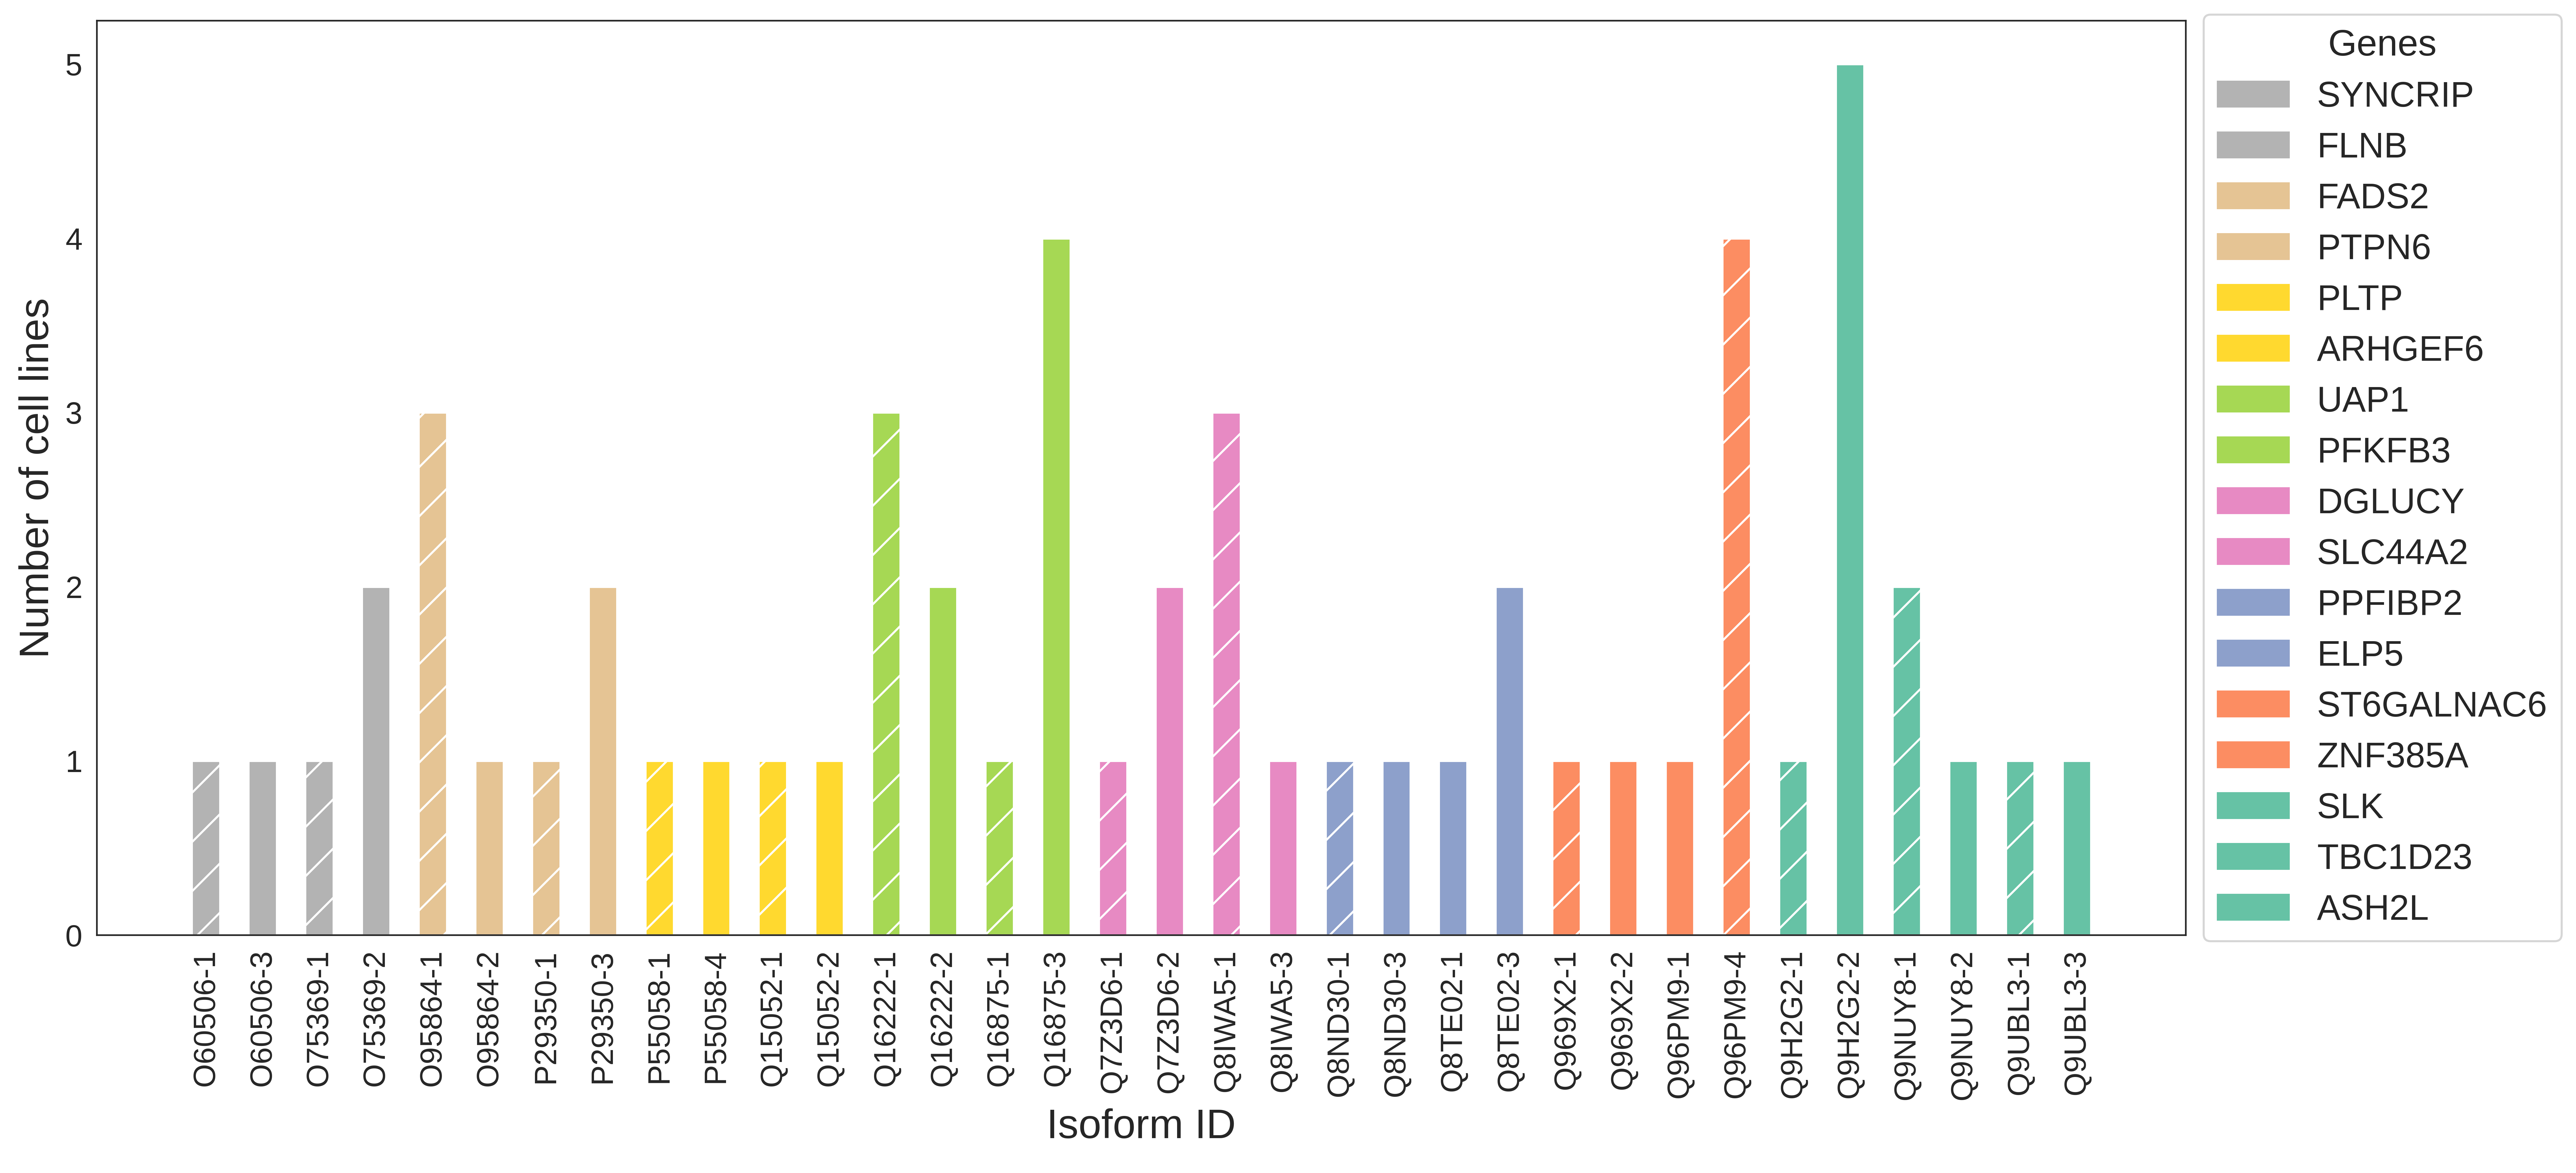

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

df_sorted = duplicates_can.sort_values(by='isoform_id')

# Assuming 'df_sorted' has been defined elsewhere and includes a 'gene' column
unique_genes = df_sorted['gene'].unique()
# Using 'Set3' which has brighter, more vibrant colors
colors = plt.cm.Set2_r(np.linspace(0, 1, len(unique_genes)))
color_map = dict(zip(unique_genes, colors))

bar_width = 0.5

plt.figure(figsize=(15, 8), dpi=500)
for gene in unique_genes:
    subset = df_sorted[df_sorted['gene'] == gene]
    labels = [f"{isoform}" for isoform in subset['isoform_id']]
    for i, (label, count, is_canonical) in enumerate(zip(labels, subset['count_more_than_5'], subset['isMain'])):
        color = color_map[gene]
        bar = plt.bar(label, count, label=gene if i == 0 else "", color=color, width=bar_width)
        if is_canonical == "primary sequence":
            bar[0].set_hatch('/')

plt.xlabel('Isoform ID', fontsize=20)
plt.ylabel('Number of cell lines', fontsize=20)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
legend_patches = [Patch(color=color_map[gene], label=gene) for gene in unique_genes]
plt.legend(handles=legend_patches, title="Genes", title_fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 'xx-large')

#plt.legend(title="Genes", fontsize = 'xx-large' ,title_fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))
plt.style.use('seaborn-whitegrid')
plt.savefig('your path/hist_switch.png')
plt.show()

 Occurrence of switching splice variants among ten cell lines. Y axis reflects the number of cell lines where this isoform variant is expressed. Shaded bars indicate canonical splice forms